# Imports

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error 

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import accuracy_score
import shap

warnings.filterwarnings('ignore')

c:\Users\USER\Desktop\Personal\Bits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd


In [113]:
# Load your dataset
df = pd.read_csv("../../data/output.csv")

# Train & Test Split

The train.csv and test.csv files have been loaded successfully.


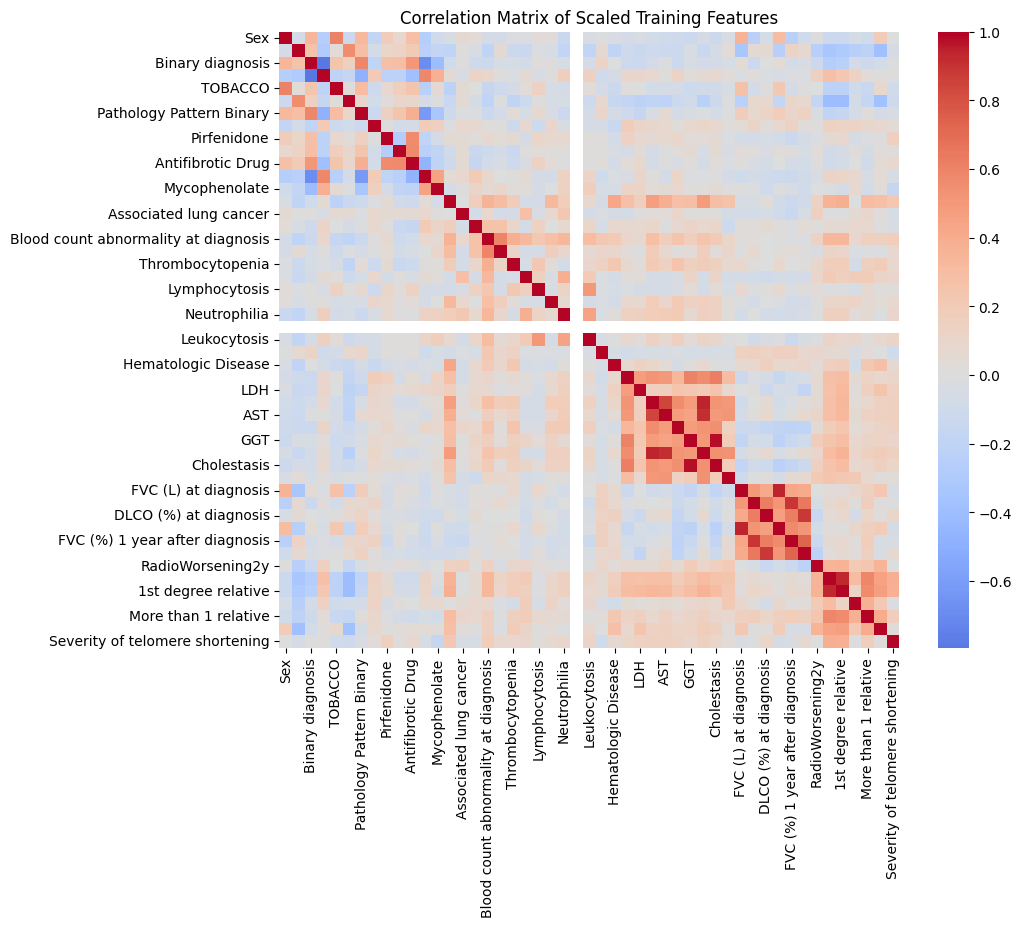

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the train and test datasets
train = pd.read_csv("../../data/train_y2.csv")
test = pd.read_csv("../../data/test_y2.csv")

# Separate features and the two target variables
X_train = train.drop(["Death", "Progressive disease"], axis=1)
y_train_death = train["Death"]
y_train_prog = train["Progressive disease"]



X_test = test.drop(["Death", "Progressive disease"], axis=1)
y_test_death = test["Death"]
y_test_prog = test["Progressive disease"]
print("The train.csv and test.csv files have been loaded successfully.")

# Optional: Scale the data if needed
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
X_train_scaled = X_train
X_test_scaled = X_test


X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Plot correlation matrix to explore relationships
plt.figure(figsize=(10,8))
sns.heatmap(X_train_scaled_df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Scaled Training Features")
plt.show()


In [117]:
# X_train["FVCDiff"] = X_train["FVC (%) 1 year after diagnosis"]- X_train["FVC (%) at diagnosis"] #<5%
# X_train["FVCDiff"] = X_train["FVCDiff"] <= -5
# X_train["FVCDiff"] = X_train["FVCDiff"].astype(int)


# X_test["FVCDiff"] = X_test["FVC (%) 1 year after diagnosis"]- X_test["FVC (%) at diagnosis"] #<5%
# X_test["FVCDiff"] = X_test["FVCDiff"] <= -5
# X_test["FVCDiff"] = X_test["FVCDiff"].astype(int)

# X_train["DLCODiff"] = X_train["DLCO (%) 1 year after diagnosis"]- X_train["DLCO (%) at diagnosis"] #<10%
# X_train["DLCODiff"] = X_train["DLCODiff"] <= -10
# X_train["DLCODiff"] = X_train["DLCODiff"].astype(int)


# X_test["DLCODiff"] = X_test["DLCO (%) 1 year after diagnosis"]- X_test["DLCO (%) at diagnosis"] #<10%
# X_test["DLCODiff"] = X_test["DLCODiff"] <= -10
# X_test["DLCODiff"] = X_test["DLCODiff"].astype(int)

# X_train.drop(["FVC (%) 1 year after diagnosis", "FVC (%) at diagnosis", "DLCO (%) 1 year after diagnosis", "DLCO (%) at diagnosis"], axis=1, inplace=True)
# X_test.drop(["FVC (%) 1 year after diagnosis", "FVC (%) at diagnosis", "DLCO (%) 1 year after diagnosis", "DLCO (%) at diagnosis"], axis=1, inplace=True)

In [118]:
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Eda

## Missings

In [119]:
# Print how many missing values are in the dataset
print("The number of missing values in the dataset are:")
print(X_train.isnull().sum())
print(X_test.isnull().sum())

The number of missing values in the dataset are:
Sex                                     0
Age at diagnosis                        0
Binary diagnosis                        0
Final diagnosis                         0
TOBACCO                                 0
Comorbidities                           0
Pathology Pattern Binary                0
Multidsciplinary committee              0
Pirfenidone                             0
Nintedanib                              0
Antifibrotic Drug                       0
Prednisone                              0
Mycophenolate                           0
Extrapulmonary affectation              0
Associated lung cancer                  0
Other cancer                            0
Blood count abnormality at diagnosis    0
Anemia                                  0
Thrombocytopenia                        0
Thrombocytosis                          0
Lymphocytosis                           0
Lymphopenia                             0
Neutrophilia               

## Outliers

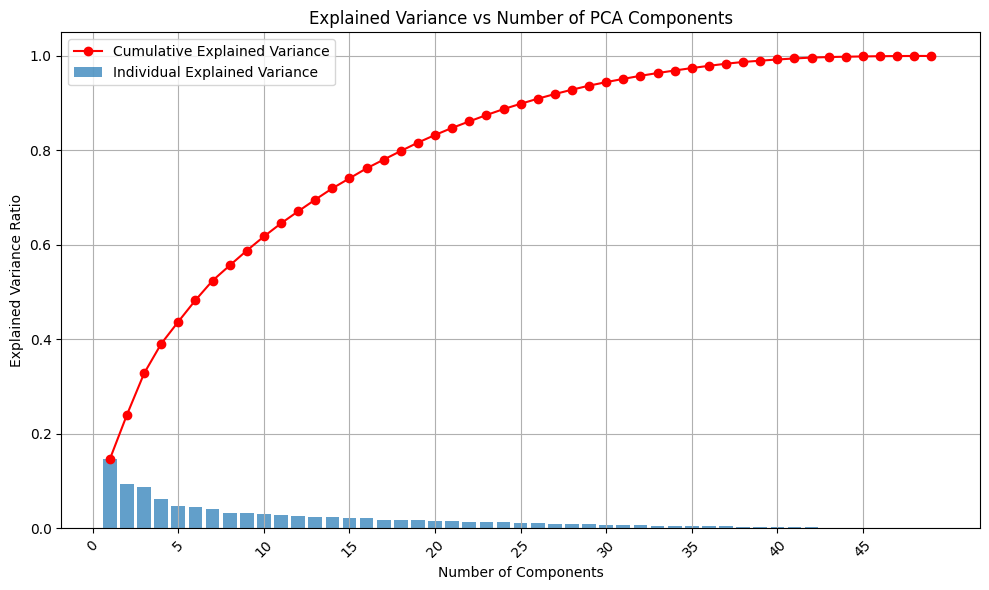

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

# Number of components
components = np.arange(1, len(explained_var_ratio) + 1)

plt.figure(figsize=(10, 6))

# Bar plot for individual explained variance
plt.bar(components, explained_var_ratio, alpha=0.7, label='Individual Explained Variance')

# Line plot for cumulative explained variance
plt.plot(components, cumulative_var_ratio, marker='o', color='red', label='Cumulative Explained Variance')

# Set labels and title
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance vs Number of PCA Components')

# Adjust ticks
# Show fewer ticks, for example every 5 components
plt.xticks(np.arange(0, len(components)+1, 5))
# Rotate tick labels if needed
plt.xticks(rotation=45)

plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## Model

In [121]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb

def objective_death(trial):
    # Definir el conjunto de hiperparámetros a optimizar
    param = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': trial.suggest_int('num_leaves', 31, 256),  # Mejores resultados suelen estar entre 31 y 256
    'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),  # Baja LR con más iteraciones mejora generalización
    'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.95),  # Fracción típica entre 60% y 95%
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.95),  # Similar al feature_fraction
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),  # Más común entre 1 y 7
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),  # Regularización ligera a moderada
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),  # Igual para L2
    'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),  # Ayuda a evitar overfitting en hojas pequeñas
    'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),  # Controla peso mínimo en hojas
    'max_bin': trial.suggest_int('max_bin', 128, 512),  # Más bins ayuda con datos continuos
    'num_iterations': trial.suggest_int('num_iterations', 100, 1000)  # Número de iteraciones
    }


    # K-Fold Cross-Validation
    n_splits = 5  # Número de folds
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, valid_idx in skf.split(X_train_scaled_df, y_train_death):
        # Separar los datos en folds
        X_train_fold, X_valid_fold = X_train_scaled_df.iloc[train_idx], X_train_scaled_df.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_death.iloc[train_idx], y_train_death.iloc[valid_idx]

        # Crear los datasets de LightGBM
        train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
        valid_data = lgb.Dataset(X_valid_fold, label=y_valid_fold, reference=train_data)

        # Callbacks para el entrenamiento
        callbacks = [
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=0)  # silent
        ]

        # Entrenar el modelo
        model = lgb.train(
            param,
            train_data,
            valid_sets=[valid_data],
            num_boost_round=1000,
            callbacks=callbacks
        )

        # Predicciones en el fold de validación
        y_pred = (model.predict(X_valid_fold) > 0.5).astype(int)
        score = accuracy_score(y_valid_fold, y_pred)
        cv_scores.append(score)

    # Promediar los scores de los folds
    print(cv_scores)
    mean_cv_score = sum(cv_scores) / len(cv_scores)
    return mean_cv_score


In [122]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb

def objective_prog(trial):
    # Definir el conjunto de hiperparámetros a optimizar
    param = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': trial.suggest_int('num_leaves', 31, 256),  # Mejores resultados suelen estar entre 31 y 256
    'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),  # Baja LR con más iteraciones mejora generalización
    'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.95),  # Fracción típica entre 60% y 95%
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.95),  # Similar al feature_fraction
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),  # Más común entre 1 y 7
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),  # Regularización ligera a moderada
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),  # Igual para L2
    'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),  # Ayuda a evitar overfitting en hojas pequeñas
    'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),  # Controla peso mínimo en hojas
    'max_bin': trial.suggest_int('max_bin', 128, 512),  # Más bins ayuda con datos continuos
    'num_iterations': trial.suggest_int('num_iterations', 100, 1000)  # Número de iteraciones    
    }


    # K-Fold Cross-Validation
    n_splits = 5  # Número de folds
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, valid_idx in skf.split(X_train_scaled_df, y_train_prog):
        # Separar los datos en folds
        X_train_fold, X_valid_fold = X_train_scaled_df.iloc[train_idx], X_train_scaled_df.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_prog.iloc[train_idx], y_train_prog.iloc[valid_idx]

        # Crear los datasets de LightGBM
        train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
        valid_data = lgb.Dataset(X_valid_fold, label=y_valid_fold, reference=train_data)

        # Callbacks para el entrenamiento
        callbacks = [
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=0)  # silent
        ]

        # Entrenar el modelo
        model = lgb.train(
            param,
            train_data,
            valid_sets=[valid_data],
            num_boost_round=2000,
            callbacks=callbacks
        )

        # Predicciones en el fold de validación
        y_pred = (model.predict(X_valid_fold) > 0.5).astype(int)
        score = accuracy_score(y_valid_fold, y_pred)
        cv_scores.append(score)

    # Promediar los scores de los folds
    mean_cv_score = sum(cv_scores) / len(cv_scores)
    return mean_cv_score


In [134]:
%%capture

import optuna
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def objective_death_(trial):
    # Suggest a set of hyperparameters for this trial
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0)

    }

    train_data_death = lgb.Dataset(X_train_scaled_df, label=y_train_death)
    valid_data_death = lgb.Dataset(X_test_scaled, label=y_test_death, reference=train_data_death)

    callbacks = [
        early_stopping(stopping_rounds=10),
        log_evaluation(period=0)  # silent
    ]

    model = lgb.train(
        param,
        train_data_death,
        valid_sets=[valid_data_death],
        num_boost_round=1000,
        callbacks=callbacks
    )

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    score = accuracy_score(y_test_death, y_pred)
    return score

def objective_prog_(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0)
    }

    train_data_prog = lgb.Dataset(X_train_scaled_df, label=y_train_prog)
    valid_data_prog = lgb.Dataset(X_test_scaled, label=y_test_prog, reference=train_data_prog)

    callbacks = [
        early_stopping(stopping_rounds=10),
        log_evaluation(period=0)  # silent
    ]

    model = lgb.train(
        param,
        train_data_prog,
        valid_sets=[valid_data_prog],
        num_boost_round=2000,
        callbacks=callbacks
    )

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    score = accuracy_score(y_test_prog, y_pred)
    return score

# Optimize for "Death"
study_death = optuna.create_study(direction="maximize")
study_death.optimize(objective_death, n_trials=70)  # Increase for more exploration

# Train final model with best params for Death
best_params_death = study_death.best_params
best_params_death.update({'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'})
train_data_death = lgb.Dataset(X_train_scaled_df, label=y_train_death)
valid_data_death = lgb.Dataset(X_test_scaled, label=y_test_death, reference=train_data_death)
model_death = lgb.train(
    best_params_death,
    train_data_death,
    valid_sets=[valid_data_death],
    num_boost_round=2000,
    callbacks=[early_stopping(10), log_evaluation(period=0)]
)
y_prob_death = model_death.predict(X_test_scaled)
y_pred_death = (y_prob_death > 0.5).astype(int)
acc_death = accuracy_score(y_test_death, y_pred_death)

# Optimize for "Progressive disease"
study_prog = optuna.create_study(direction="maximize")
study_prog.optimize(objective_prog, n_trials=70)  # Increase for more exploration

# Train final model with best params for Progressive disease
best_params_prog = study_prog.best_params
best_params_prog.update({'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'})
train_data_prog = lgb.Dataset(X_train_scaled_df, label=y_train_prog)
valid_data_prog = lgb.Dataset(X_test_scaled, label=y_test_prog, reference=train_data_prog)
model_prog = lgb.train(
    best_params_prog,
    train_data_prog,
    valid_sets=[valid_data_prog],
    num_boost_round=2000,
    callbacks=[early_stopping(10), log_evaluation(period=0)]
)
y_prob_prog = model_prog.predict(X_test_scaled)
y_pred_prog = (y_prob_prog > 0.5).astype(int)
acc_prog = accuracy_score(y_test_prog, y_pred_prog)



In [135]:
print(acc_death, acc_prog)
print(classification_report(y_test_death, y_pred_death))
print(classification_report(y_test_prog, y_pred_prog))

0.8181818181818182 0.8787878787878788
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        23
           1       0.83      0.50      0.62        10

    accuracy                           0.82        33
   macro avg       0.82      0.73      0.75        33
weighted avg       0.82      0.82      0.80        33

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.92      0.80      0.86        15

    accuracy                           0.88        33
   macro avg       0.89      0.87      0.88        33
weighted avg       0.88      0.88      0.88        33



In [125]:
# Show top 5 Trials for each study
print("Top 5 Trials for 'Death':")
df_death = study_death.trials_dataframe().sort_values("value", ascending=False)
print(df_death.head())

print("\nTop 5 Trials for 'Progressive disease':")
df_prog = study_prog.trials_dataframe().sort_values("value", ascending=False)
print(df_prog.head())

Top 5 Trials for 'Death':
    number     value             datetime_start          datetime_complete  \
47      47  0.848485 2024-12-15 10:03:37.797246 2024-12-15 10:03:37.907473   
66      66  0.848485 2024-12-15 10:03:39.748290 2024-12-15 10:03:39.861084   
63      63  0.848485 2024-12-15 10:03:39.471019 2024-12-15 10:03:39.560385   
64      64  0.848485 2024-12-15 10:03:39.560385 2024-12-15 10:03:39.638517   
67      67  0.848485 2024-12-15 10:03:39.869094 2024-12-15 10:03:39.980397   

                 duration  params_bagging_fraction  params_bagging_freq  \
47 0 days 00:00:00.110227                 0.884377                    1   
66 0 days 00:00:00.112794                 0.947201                    6   
63 0 days 00:00:00.089366                 0.946202                    3   
64 0 days 00:00:00.078132                 0.944407                    5   
67 0 days 00:00:00.111303                 0.945414                    6   

    params_feature_fraction  params_lambda_l1  params_

In [133]:
from sklearn.metrics import classification_report
# Train final model with best params for Death
best_params_death = study_death.best_params
best_params_death.update({'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'})
train_data_death = lgb.Dataset(X_train_scaled_df, label=y_train_death)
valid_data_death = lgb.Dataset(X_test_scaled, label=y_test_death, reference=train_data_death)

model_death = lgb.train(
    best_params_death,
    train_data_death,
    valid_sets=[valid_data_death],
    num_boost_round=2000,
    callbacks=[early_stopping(10), log_evaluation(period=0)]
)


best_params_prog = study_prog.best_params
best_params_prog.update({'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt'})
train_data_prog = lgb.Dataset(X_train_scaled_df, label=y_train_prog)
valid_data_prog = lgb.Dataset(X_test_scaled, label=y_test_prog, reference=train_data_prog)

model_prog = lgb.train(
    best_params_prog,
    train_data_prog,
    valid_sets=[valid_data_prog],
    num_boost_round=2000,
    callbacks=[early_stopping(10), log_evaluation(period=0)]

)
# Save the "Death" model
model_prog.save_model("prog_model_y2.txt")
model_death.save_model("death_model_y2.txt")

y_prob_death = model_death.predict(X_test_scaled)
y_pred_death = (y_prob_death > 0.5).astype(int)
acc_death = accuracy_score(y_test_death, y_pred_death)

y_prob_prog = model_prog.predict(X_test_scaled)
y_pred_prog = (y_prob_prog > 0.5).astype(int)
acc_prog = accuracy_score(y_test_prog, y_pred_prog)
print(classification_report(y_test_death, y_pred_death))
print(classification_report(y_test_prog, y_pred_prog))
print(acc_death, acc_prog)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 50, number of negative: 137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 187, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267380 -> initscore=-1.007958
[LightGBM] [Info] Start training from score -1.007958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [127]:
print("Accuracy for 'Death':", acc_death)

#            death        progressive disease
# y0 = 0.8787878787878788 0.8181818181818182
# y1 = 0.8484848484848485 0.8181818181818182
# y2 = 0.8787878787878788 0.9090909090909091

Accuracy for 'Death': 0.8484848484848485


In [128]:
loaded_model_death = lgb.Booster(model_file="../model_weights/prog_model_y1.txt")
loaded_model_death = lgb.Booster(model_file="prog_model_y1.txt")

# Use loaded_model_death.predict(...) as before
y_prob_prog = loaded_model_death.predict(X_test)
y_pred_prog = (y_prob_prog > 0.5).astype(int)
acc_prog = accuracy_score(y_test_prog, y_pred_prog)
print(classification_report(y_test_prog, y_pred_prog))	

LightGBMError: The number of features in data (49) is not the same as it was in training data (48).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [109]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Convert DataFrames/numpy arrays if needed
X_train = X_train_scaled_df.values  # Ensure this is a numpy array
X_test = X_test_scaled  # Already assumed to be numpy array

def build_complex_mlp(input_dim, l2_strength=0.002, dropout_rate=0.5):
    model = models.Sequential()
    # First layer
    model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,),
                           kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Second layer
    model.add(layers.Dense(64, activation='relu',
                           kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Third layer
    model.add(layers.Dense(32, activation='relu',
                           kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Use a slightly lower learning rate for Adam, or try AdamW if available
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

input_dim = X_train.shape[1]

# Early stopping with increased patience
es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Learning rate scheduler to reduce LR when no improvement in val_loss
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# ===========================================
# Model for "Death"
# ===========================================
model_death = build_complex_mlp(input_dim, l2_strength=0.002, dropout_rate=0.5)

history_death = model_death.fit(
    X_train, y_train_death,
    validation_split=0.2,
    epochs=200,  # increased epochs for better exploration
    batch_size=32,
    callbacks=[es, rlr],
    verbose=0
)

# Evaluate on test
y_prob_death = model_death.predict(X_test)
y_pred_death = (y_prob_death > 0.5).astype(int)
acc_death = accuracy_score(y_test_death, y_pred_death)
print("Final test accuracy for 'Death':", acc_death)

# ===========================================
# Model for "Progressive disease"
# ===========================================
model_prog = build_complex_mlp(input_dim, l2_strength=0.002, dropout_rate=0.5)

history_prog = model_prog.fit(
    X_train, y_train_prog,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es, rlr],
    verbose=0
)

# Evaluate on test
y_prob_prog = model_prog.predict(X_test)
y_pred_prog = (y_prob_prog > 0.5).astype(int)
acc_prog = accuracy_score(y_test_prog, y_pred_prog)
print("Final test accuracy for 'Progressive disease':", acc_prog)

# ===========================================
# Plotting Training Curves for Death
# ===========================================
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(history_death.history['loss'], label='train_loss')
axs[0].plot(history_death.history['val_loss'], label='val_loss')
axs[0].set_title('Death Model Loss')
axs[0].legend()

axs[1].plot(history_death.history['accuracy'], label='train_acc')
axs[1].plot(history_death.history['val_accuracy'], label='val_acc')
axs[1].set_title('Death Model Accuracy')
axs[1].legend()
plt.show()

# ===========================================
# Plotting Training Curves for Progressive Disease
# ===========================================
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(history_prog.history['loss'], label='train_loss')
axs[0].plot(history_prog.history['val_loss'], label='val_loss')
axs[0].set_title('Progressive disease Model Loss')
axs[0].legend()

axs[1].plot(history_prog.history['accuracy'], label='train_acc')
axs[1].plot(history_prog.history['val_accuracy'], label='val_acc')
axs[1].set_title('Progressive disease Model Accuracy')
axs[1].legend()
plt.show()


ModuleNotFoundError: No module named 'tensorflow'